In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import zscore
import ray
from flaml import AutoML


In [2]:
#setconfig

ray.init(num_cpus=64, ignore_reinit_error=True)
#np.setbufsize(1e6)
#np.getbufsize()

config = {
    "time_limits": 28000, # in seconds
    "early_stop": False,
    "max_threads": 4, # threads for each learner
    "parallel_trail": 16, # trails in parallel
    "log_postfix": 'trial4.log',
    "eval_method": 'cv',
    "use_model": ['lgbm', 'xgboost', 'catboost'],
    "model_weights": [1, 1, 1],
}

In [3]:
path_prefix = './cs5228-2310-final-project/'
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [4]:
def category_map(df_origin, df_train_):
    df = df_origin.copy()
    df_train_ = df_train_.copy()
    colums = ['town', 'flat_type', 'flat_type2', 'cluster', 'street_name', 'block',
              'lease_commence_date', 'flat_model', 'subzone', 'planning_area','region']
    #locations = ['town', 'block', 'street_name', 'subzone', 'planning_area','region', 'cluster']
    
    for col in colums:
        df_train_[col] = df_train_[col].astype(str).str.lower()
        df[col] = df[col].astype(str).str.lower()

    df['block'] = df['street_name'] + ' ' + df['block']
    df_train_['block'] = df_train_['street_name'] + ' ' + df_train_['block']

    for col in colums:
        group_mean = df_train_.groupby(col)['monthly_rent'].mean()
        group_std = df_train_.groupby(col)['monthly_rent'].std()
        group_median = df_train_.groupby(col)['monthly_rent'].median()
        group_cnt = df_train_[col].value_counts()
        total_mean = df_train_['monthly_rent'].mean()
        total_median = df_train_['monthly_rent'].median()
        total_std = df_train_['monthly_rent'].std()
        cat_map = group_cnt[group_cnt.values >= 16].index.tolist()
        std_map = group_std.to_dict()
        mean_map = group_mean.to_dict()
        median_map = group_median.to_dict()

        df[col] = df[col].apply(lambda x: x if x in cat_map else 'other')
        df[col+'_std'] = df[col].apply(lambda x: std_map[x] if x in cat_map else -2)
        #df[col+'_mean'] = df[col].apply(lambda x: mean_map[x] if x in cat_map else -10)
        #df[col+'_median'] = df[col].apply(lambda x: median_map[x] if x in cat_map else -10)
        #df.drop(columns=[col], inplace=True)
        
    return df


In [5]:
#add KNN feature
def add_KNN_feature(df_origin, df_pos, K: int):
    KNN_X = df_pos[['latitude', 'longitude']]
    KNN_X['latitude'] *= 2
    KNN_y = df_pos['monthly_rent']

    KNN_model = KNeighborsRegressor(n_neighbors=K)
    KNN_model.fit(KNN_X, KNN_y)

    KNN_y2 = KNN_y ** 2
    KNN_model2 = KNeighborsRegressor(n_neighbors=K)
    KNN_model2.fit(KNN_X, KNN_y2)

    predict_X = df_origin[['latitude', 'longitude']]
    predict_X['latitude'] *= 2
    predict_y = KNN_model.predict(predict_X)
    predict_y2 = KNN_model2.predict(predict_X)
    df = df_origin.copy()
    #use std to be the feature
    df['K=' + str(K) + ' KNN_std'] = np.sqrt(predict_y2 - predict_y ** 2)
    #df['K=' + str(K) + ' KNN_mean'] = predict_y

    return df

In [6]:
def data_preprocess(df, df_train_, category_mapping=True):
    df = df.copy()
    df_train_ = df_train_.copy()

    df['flat_type2'] = df['flat_type'].str.replace('-', ' ')
    df_train_['flat_type2'] = df_train_['flat_type'].str.replace('-', ' ')
    #df.drop(['block'], axis=1, inplace=True)
    
    #normalize by date
    #df['monthly_rent'] = np.log(df['monthly_rent'])
    #df_train_['monthly_rent'] = np.log(df_train_['monthly_rent'])
    means = df_train_.groupby('rent_approval_date')['monthly_rent'].mean()
    stds = df_train_.groupby('rent_approval_date')['monthly_rent'].std()
    median = df_train_.groupby('rent_approval_date')['monthly_rent'].median()

    df['monthly_rent'] = df.apply(lambda x: (x['monthly_rent'] - means[x['rent_approval_date']]) / stds[x['rent_approval_date']], axis=1)
    df_train_['monthly_rent'] = df_train_.apply(lambda x: (x['monthly_rent'] - means[x['rent_approval_date']]) / stds[x['rent_approval_date']], axis=1)
    #normalize monthly rent by date
    
    #add coe price
    df_coe = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-coe-prices.csv')
    month_to_numeric = {
        'january': 1,
        'february': 2,
        'march': 3,
        'april': 4,
        'may': 5,
        'june': 6,
        'july': 7,
        'august': 8,
        'september': 9,
        'october': 10,
        'november': 11,
        'december': 12
    }

    df_coe['month'] = df_coe['month'].apply(lambda x: month_to_numeric[x.lower()])
    df_coe['month'] = df_coe['month'].apply(lambda x: f'{x:02d}')

    df_coe['date'] = df_coe['year'].astype(str) + '-' + df_coe['month']
    df_coe['date'] = pd.to_datetime(df_coe['date'])
    df_coe = df_coe[['date', 'price']]
    avg_price_bids_quota = df_coe.groupby('date').mean().reset_index()
    avg_price_bids_quota['date'] = pd.to_datetime(avg_price_bids_quota['date'])

    df['coe_price'] = df['rent_approval_date'].apply(lambda x: avg_price_bids_quota[avg_price_bids_quota['date'] == x]['price'].values[0])

    
    if category_mapping:
        df = category_map(df, df_train_)
    df.drop(['elevation'], axis=1, inplace=True)
    df.drop(['furnished'], axis=1, inplace=True)


    
    for K in [16, 32, 64, 128]:
        df = add_KNN_feature(df, df_train_, K)
    
    #df['date_mean'] = df['rent_approval_date'].apply(lambda x: means[x])
    df['date_std'] = df['rent_approval_date'].apply(lambda x: stds[x])
    #df['date_median'] = df['rent_approval_date'].apply(lambda x: median[x])
 
    #df.drop(['latitude'], axis=1, inplace=True)
    #df.drop(['longitude'], axis=1, inplace=True)
    #df['rent_approval_date'] = pd.to_datetime(df['rent_approval_date']).astype('int64')
    df.drop(['rent_approval_date'], axis=1, inplace=True)
    #df.drop(['block'], axis=1, inplace=True)

    return df

In [7]:
def handle_outliers(group, attribute):
    z_scores = zscore(group[attribute])
    threshold = 3 
    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
    print(len(outlier_indices))
    return group[(z_scores < threshold)]  

In [8]:
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')
df_test['monthly_rent'] = -1
#df_train['rent_approval_date'] = pd.to_datetime(df_train['rent_approval_date']).astype('int64')
#df_test['rent_approval_date'] = pd.to_datetime(df_test['rent_approval_date']).astype('int64')

In [9]:
df_train = df_train.groupby(df_train.columns.tolist()).mean().reset_index()
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-01,ang mo kio,105,ang mo kio avenue 4,4 room,new generation,92.0,yes,1978,1.372313,103.837601,0.0,kebun bahru,ang mo kio,north-east region,2100
1,2021-01,ang mo kio,107,ang mo kio avenue 4,3 room,new generation,74.0,yes,1978,1.371384,103.837381,0.0,kebun bahru,ang mo kio,north-east region,1850
2,2021-01,ang mo kio,108,Ang Mo Kio Avenue 4,3 room,new generation,67.0,yes,1978,1.370966,103.838202,0.0,kebun bahru,ang mo kio,north-east region,1850
3,2021-01,ang mo kio,111,ang mo kio avenue 4,5 room,improved,117.0,yes,1978,1.370851,103.837298,0.0,kebun bahru,ang mo kio,north-east region,2350
4,2021-01,ang mo kio,111,ang mo kio avenue 4,5 room,improved,117.0,yes,1978,1.370851,103.837298,0.0,kebun bahru,ang mo kio,north-east region,2550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59722,2023-07,yishun,854,yishun ring road,4-room,model a,104.0,yes,1988,1.416597,103.837403,0.0,yishun south,yishun,north region,2100
59723,2023-07,yishun,867,Yishun Street 81,4-room,simplified,84.0,yes,1988,1.413906,103.838005,0.0,yishun south,yishun,north region,3150
59724,2023-07,yishun,874,Yishun Street 81,4-room,model a,104.0,yes,1988,1.415370,103.836074,0.0,yishun south,yishun,north region,2100
59725,2023-07,yishun,930,Yishun Central 1,4-room,model a,104.0,yes,1993,1.426915,103.837351,0.0,yishun central,yishun,north region,3350


In [10]:
# handle outlier
grouped = df_train.groupby('rent_approval_date', group_keys=False)
df_train = grouped.apply(handle_outliers, attribute='monthly_rent')
df_train.reset_index(drop=True, inplace=True)

16
6
16
12
15
6
13
9
6
6
8
8
3
2
5
9
11
6
17
1
15
10
5
5
7
7
5
9
5
7
7


<Axes: xlabel='latitude', ylabel='longitude'>

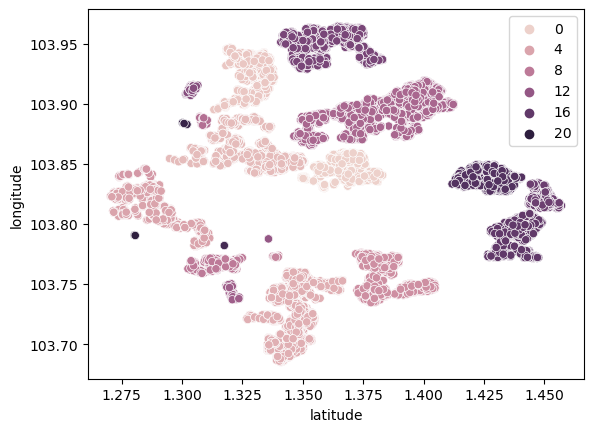

In [11]:
#add cluster feature
df_lat_long = df_train[['latitude', 'longitude']]
df_lat_long_test = df_test[['latitude', 'longitude']]
df_total = pd.concat([df_lat_long, df_lat_long_test], axis=0)
from sklearn.cluster import DBSCAN
DBSCAN_model = DBSCAN(eps=0.005, min_samples=1)
DBSCAN_model.fit(df_total)
#plot
sns.scatterplot(x='latitude', y='longitude', hue=DBSCAN_model.labels_, data=df_total)


In [12]:
df_train['cluster'] = DBSCAN_model.labels_[:len(df_train)]
df_test['cluster'] = DBSCAN_model.labels_[len(df_train):]

In [13]:
ds_train_processed = data_preprocess(df_train, df_train)
#ds_train_unmapped = data_preprocess(df_train, df_train, category_mapping=False)
#ds_test_processed = data_preprocess(df_test, df_train)
#ds_test_unmapped = data_preprocess(df_test, df_train, category_mapping=False)
ds_train_processed

C:\Users\Concyclics\AppData\Local\Temp\ipykernel_50624\3265072544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KNN_X['latitude'] *= 2
C:\Users\Concyclics\AppData\Local\Temp\ipykernel_50624\3265072544.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_X['latitude'] *= 2
C:\Users\Concyclics\AppData\Local\Temp\ipykernel_50624\3265072544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,...,lease_commence_date_std,flat_model_std,subzone_std,planning_area_std,region_std,K=16 KNN_std,K=32 KNN_std,K=64 KNN_std,K=128 KNN_std,date_std
0,ang mo kio,other,ang mo kio avenue 4,4 room,new generation,92.0,1978,1.372313,103.837601,kebun bahru,...,0.979795,0.853596,0.889012,0.898254,0.901892,1.128227,0.960492,0.962073,0.889475,367.593724
1,ang mo kio,other,ang mo kio avenue 4,3 room,new generation,74.0,1978,1.371384,103.837381,kebun bahru,...,0.979795,0.853596,0.889012,0.898254,0.901892,0.925968,0.796774,0.720564,0.855265,367.593724
2,ang mo kio,other,ang mo kio avenue 4,3 room,new generation,67.0,1978,1.370966,103.838202,kebun bahru,...,0.979795,0.853596,0.889012,0.898254,0.901892,0.879188,0.785863,0.873956,0.857204,367.593724
3,ang mo kio,other,ang mo kio avenue 4,5 room,improved,117.0,1978,1.370851,103.837298,kebun bahru,...,0.979795,0.997132,0.889012,0.898254,0.901892,1.085068,0.916964,0.799834,0.790365,367.593724
4,ang mo kio,other,ang mo kio avenue 4,5 room,improved,117.0,1978,1.370851,103.837298,kebun bahru,...,0.979795,0.997132,0.889012,0.898254,0.901892,1.085068,0.916964,0.799834,0.790365,367.593724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59522,yishun,other,yishun ring road,4-room,model a,104.0,1988,1.416597,103.837403,yishun south,...,0.965515,1.001261,0.913461,0.899400,0.911481,0.958680,0.852762,0.893715,0.924625,800.840121
59523,yishun,other,yishun street 81,4-room,simplified,84.0,1988,1.413906,103.838005,yishun south,...,0.965515,0.905838,0.913461,0.899400,0.911481,0.839226,0.804646,0.932338,1.008750,800.840121
59524,yishun,other,yishun street 81,4-room,model a,104.0,1988,1.415370,103.836074,yishun south,...,0.965515,1.001261,0.913461,0.899400,0.911481,1.235255,1.090222,1.070742,0.985053,800.840121
59525,yishun,other,yishun central 1,4-room,model a,104.0,1993,1.426915,103.837351,yishun central,...,0.896048,1.001261,0.727821,0.899400,0.911481,0.557795,0.677977,0.675240,0.720290,800.840121


In [14]:
df_norm = df_train.copy()
#df_norm['monthly_rent'] = np.log(df_norm['monthly_rent'])
means = df_norm.groupby('rent_approval_date')['monthly_rent'].mean()
stds = df_norm.groupby('rent_approval_date')['monthly_rent'].std()

In [15]:
X = ds_train_processed.drop(['monthly_rent'], axis=1)
cat_cols = ['town', 'flat_type', 'flat_type2', 'cluster', 'street_name', 'block',
              'lease_commence_date', 'flat_model', 'subzone', 'planning_area','region']
X_cat = X
X = X.drop(cat_cols, axis=1)
#X.drop(['rent_approval_date'], axis=1, inplace=True)
y = df_train['monthly_rent'] - means[df_train['rent_approval_date']].reset_index(drop=True)
#X = X[best_features]
#X_cat = ds_train_unmapped.drop(['monthly_rent'], axis=1)



#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#real_X_train, real_X_test, real_y_train, real_y_test = train_test_split(df_train, real_y, test_size=0.3, random_state=42)





In [16]:
for col in X.columns:
    if len(X[col].unique()) == 1:
        print(X[col].value_counts())

In [17]:
lgbm_best_params = {"n_estimators": 984, "num_leaves": 14, "min_child_samples": 20, "learning_rate": 0.00955415404855802, "log_max_bin": 9, "colsample_bytree": 0.1715233882278872, "reg_alpha": 0.014850297149652449, "reg_lambda": 133.998563158583}

xgb_best_params = {"n_estimators": 1916, "max_leaves": 41, "min_child_weight": 2.801525277874866, "learning_rate": 0.008298317608896174, "subsample": 0.6353412977381421, "colsample_bylevel": 0.41285744272632785, "colsample_bytree": 0.28604232010408714, "reg_alpha": 0.0011682284135139422, "reg_lambda": 5.118367390261997}

cat_best_params = {"early_stopping_rounds": 10, "learning_rate": 0.0357338948551828, "n_estimators": 230}

In [18]:
automl_settings_lightgbm = {
    "time_budget": config['time_limits'],
    "early_stop": config['early_stop'],
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['lgbm'],
    "eval_method": config['eval_method'],
    "log_file_name": 'lgbm_' + config['log_postfix'],
    "n_jobs": config['max_threads'],
    "n_concurrent_trials": config['parallel_trail'],

}

automl_settings_xgboost = {
    "time_budget": config['time_limits'],
    "early_stop": config['early_stop'],
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['xgb_limitdepth'],
    "eval_method": config['eval_method'],
    "log_file_name": 'xgboost_' + config['log_postfix'],
    "n_jobs": config['max_threads'],
    "n_concurrent_trials": config['parallel_trail'],

}

automl_settings_catboost = {
    "time_budget": config['time_limits'],
    "early_stop": config['early_stop'],
    "metric": 'rmse',
    "task": 'regression',
    "estimator_list": ['catboost'],
    "eval_method": config['eval_method'],
    "log_file_name": 'catboost_' + config['log_postfix'],
    "n_jobs": config['max_threads'],
    "n_concurrent_trials": config['parallel_trail'],

}

lightgbm_automl = AutoML()

catboost_automl = AutoML()

xgboost_automl = AutoML()

In [19]:
if 'lgbm' in config['use_model']:
    lightgbm_automl.fit(X_train=X, y_train=y, **automl_settings_lightgbm)#, starting_points=lgbm_best_params)

if 'catboost' in config['use_model']:
    catboost_automl.fit(X_train=X_cat, y_train=y, **automl_settings_catboost)#, starting_points=cat_best_params)

if 'xgboost' in config['use_model']:
    xgboost_automl.fit(X_train=X, y_train=y, **automl_settings_xgboost)#, starting_points=xgb_best_params)

[flaml.automl.logger: 10-29 21:23:55] {1679} INFO - task = regression
[flaml.automl.logger: 10-29 21:23:55] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 10-29 21:23:55] {1788} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 10-29 21:23:55] {1900} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 10-29 21:23:55] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-29 21:23:56] {2344} INFO - Estimated sufficient time budget=5823s. Estimated necessary time budget=6s.
[flaml.automl.logger: 10-29 21:23:56] {2391} INFO -  at 0.7s,	estimator lgbm's best error=549.6600,	best estimator lgbm's best error=549.6600
[flaml.automl.logger: 10-29 21:23:56] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-29 21:23:56] {2391} INFO -  at 1.4s,	estimator lgbm's best error=549.6600,	best estimator lgbm's best error=549.6600
[flaml.automl.logger: 10-29 21:23:56] {2218} INFO - iteration 2, current learner lgbm
[flaml.a

In [20]:
#plot importance of xgboost
feature_importance_xgb = xgboost_automl.model.estimator.feature_importances_ / xgboost_automl.model.estimator.feature_importances_.sum()
feature_importance_lgbm = lightgbm_automl.model.estimator.feature_importances_ / lightgbm_automl.model.estimator.feature_importances_.sum()
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance_xgb': feature_importance_xgb, 'importance_lgbm': feature_importance_lgbm, 'importance_total': feature_importance_xgb + feature_importance_lgbm})
feature_importance_df.sort_values(by=['importance_lgbm'], ascending=False, inplace=True)
feature_importance_df.to_csv('feature_importance.csv', index=False)
feature_importance_df

,feature,importance_xgb,importance_lgbm,importance_total
3,coe_price,0.009930,0.096630,0.106560
15,K=16 KNN_std,0.006366,0.084935,0.091300
2,longitude,0.008539,0.084099,0.092639
19,date_std,0.012685,0.083264,0.095949
1,latitude,0.029370,0.079922,0.109292
0,floor_area_sqm,0.045317,0.078251,0.123568
16,K=32 KNN_std,0.004216,0.077973,0.082189
17,K=64 KNN_std,0.004012,0.076580,0.080593
18,K=128 KNN_std,0.004042,0.061264,0.065306
8,street_name_std,0.007046,0.054302,0.061348


In [21]:

df_test['monthly_rent'] = 0

ds_test_processed = data_preprocess(df_test, df_train)
ds_test_processed.drop(['monthly_rent'], axis=1, inplace=True)
X_test = ds_test_processed
X_test_cat = X_test
X_test = X_test.drop(cat_cols, axis=1)
#ds_test_processed.drop(['rent_approval_date'], axis=1, inplace=True)
if 'lgbm' in config['use_model']:
    y_pred_lightgbm = lightgbm_automl.predict(X_test)
    y_pred_lightgbm += means[df_test['rent_approval_date']].reset_index(drop=True)
if 'catboost' in config['use_model']:
    y_pred_catboost = catboost_automl.predict(X_test_cat)
    y_pred_catboost += means[df_test['rent_approval_date']].reset_index(drop=True)
if 'xgboost' in config['use_model']:
    y_pred_xgboost = xgboost_automl.predict(X_test)
    y_pred_xgboost += means[df_test['rent_approval_date']].reset_index(drop=True)



C:\Users\Concyclics\AppData\Local\Temp\ipykernel_50624\3265072544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KNN_X['latitude'] *= 2
C:\Users\Concyclics\AppData\Local\Temp\ipykernel_50624\3265072544.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_X['latitude'] *= 2
C:\Users\Concyclics\AppData\Local\Temp\ipykernel_50624\3265072544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [22]:
submission = pd.read_csv(path_prefix + 'example-submission.csv')
if 'lgbm' in config['use_model']:
    submission['Predicted'] = y_pred_lightgbm
    submission.to_csv('submission_lightgbm.csv', index=False)
if 'catboost' in config['use_model']:
    submission['Predicted'] = y_pred_catboost
    submission.to_csv('submission_catboost.csv', index=False)
if 'xgboost' in config['use_model']:
    submission['Predicted'] = y_pred_xgboost
    submission.to_csv('submission_xgboost.csv', index=False)

y_mean = 0
y_square_mean = 0
y_harmonic_mean = 0
y_geometric_mean = 0

if 'lgbm' in config['use_model']:
    y_mean += y_pred_lightgbm * config['model_weights'][config['use_model'].index('lgbm')]
    y_square_mean += y_pred_lightgbm ** 2 * config['model_weights'][config['use_model'].index('lgbm')]
    y_harmonic_mean += 1 / y_pred_lightgbm * config['model_weights'][config['use_model'].index('lgbm')]
    y_geometric_mean *= y_pred_lightgbm ** config['model_weights'][config['use_model'].index('lgbm')]
if 'catboost' in config['use_model']:
    y_mean += y_pred_catboost * config['model_weights'][config['use_model'].index('catboost')]
    y_square_mean += y_pred_catboost ** 2 * config['model_weights'][config['use_model'].index('catboost')]
    y_harmonic_mean += 1 / y_pred_catboost * config['model_weights'][config['use_model'].index('catboost')]
    y_geometric_mean *= y_pred_catboost ** config['model_weights'][config['use_model'].index('catboost')]
if 'xgboost' in config['use_model']:
    y_mean += y_pred_xgboost * config['model_weights'][config['use_model'].index('xgboost')]
    y_square_mean += y_pred_xgboost ** 2 * config['model_weights'][config['use_model'].index('xgboost')]
    y_harmonic_mean += 1 / y_pred_xgboost * config['model_weights'][config['use_model'].index('xgboost')]
    y_geometric_mean *= y_pred_xgboost ** config['model_weights'][config['use_model'].index('xgboost')]

y_mean /= sum(config['model_weights'])
y_square_mean /= sum(config['model_weights'])
y_square_mean = np.sqrt(y_square_mean)
y_harmonic_mean = sum(config['model_weights']) / y_harmonic_mean
y_geometric_mean = y_geometric_mean ** (1 / sum(config['model_weights']))

submission['Predicted'] = y_mean
submission.to_csv('submission_mean.csv', index=False)
submission['Predicted'] = y_square_mean
submission.to_csv('submission_square_mean.csv', index=False)
submission['Predicted'] = y_harmonic_mean
submission.to_csv('submission_harmonic_mean.csv', index=False)
submission['Predicted'] = y_geometric_mean
submission.to_csv('submission_geometric_mean.csv', index=False)
